<a href="https://colab.research.google.com/github/danielesasso/PySpark-csv-query-with-LLM/blob/main/demo_Colab_PySpark_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto big data

## 1. Inizializzazione
* pre-requisiti: file csv suddiviso tassonomicamente (e.g: "skill-Linux") e un blocco ID (e.g:"ID-name")

In [ ]:
!pip install pandas numpy matplotlib IPython html

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


### 1.1 librerie

In [ ]:
import pandas as pd
import numpy as np
import os
import json

import openai
from functools import reduce

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



## 2. apertura csv
apro un file csv tassonomico e prendo una porzione del dataset

In [ ]:
df = pd.read_csv('populated_matrix.csv')
df = df.iloc[:, :30]
df = df.head(100)


In [ ]:
skill_only_columns = [col for col in df.select_dtypes(include=[np.number]).columns.tolist() if not col.startswith("ID-")]

col_weights_dict = {col: round(np.random.rand(), 1) for col in skill_only_columns}


### 2.3 assegno i pesi (casuali) alle feature per testarlo

In [ ]:
# 2) Calcolo punteggio pesato
weighted_scores = []
for idx, row in df.iterrows():
    score = 0.0
    for col in skill_only_columns:
        skill_value = row[col]  # 0 o 1
        weight = col_weights_dict.get(col, 0)
        score += skill_value * weight
    weighted_scores.append(score)

df['weighted_score'] = weighted_scores

# 3) Ordiniamo i dati in base al punteggio pesato
df_sorted = df.sort_values('weighted_score', ascending=False)

# 4) Rimuove l'ultima colonna da pdf_sorted
df_sorted.drop(columns=[df_sorted.columns[-1]], inplace=True)

# Creiamo una mappa "peso → frazione" per usare un unico colore per colonne con lo stesso peso
unique_weights = sorted({col_weights_dict.get(c, 0) for c in skill_only_columns})
if len(unique_weights) > 1:
    min_w, max_w = unique_weights[0], unique_weights[-1]
    weight_to_fraction = {
        w: (w - min_w) / (max_w - min_w)
        for w in unique_weights
    }
else:
    # Se esiste un solo peso (o nessuno), assegniamo una frazione fissa
    weight_to_fraction = {w: 0.5 for w in unique_weights}

## 3. visualizzazione grafici
* elenca gli utenti, quelli con più skill saranno nei primi posti
* crea una "heatmap" ibrida per interpretare meglio i dati

### 3.1 tabella con heatmap

Ci sono 100 utenti, quanti ne vuoi visualizzare? (inserisci un numero o 'tutti'): 20


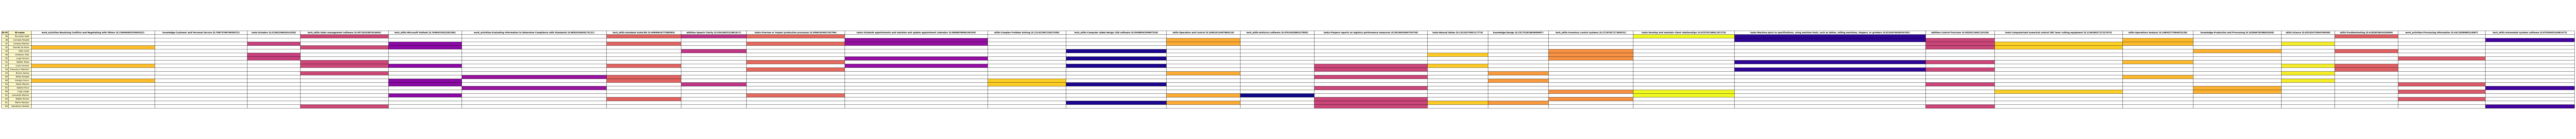

In [ ]:

pdf_table = df_sorted.copy()  # Cloniamo pdf_sorted

num_users = len(pdf_table)
scelta = input(f"Ci sono {num_users} utenti, quanti ne vuoi visualizzare? (inserisci un numero o 'tutti'): ")

if scelta.lower() == 'tutti':
    # Non applichiamo filtri, pdf_table rimane intatto
    pass
else:
    try:
        n = int(scelta)
        # Se l'utente inserisce un numero maggiore del totale utenti, mostriamo comunque tutti
        if n > num_users:
            n = num_users
        pdf_table = pdf_table.head(n)
    except ValueError:
        # Se l'input non è un numero, mostriamo a prescindere tutti gli utenti
        print("Input non valido, mostro tutti gli utenti:")

# Se dopo la selezione il DataFrame è vuoto, segnaliamo che non ci sono utenti
if pdf_table.empty:
    print("Non ci sono utenti da visualizzare.")

# -----------------------------------------------------------------------------
# Creazione della tabella basata su pdf_table
# -----------------------------------------------------------------------------

# Creiamo la figura e l'axes
fig, ax = plt.subplots(figsize=(14, 0.6 * len(pdf_table)))
ax.axis('off')

# Creiamo nuove etichette per le colonne che includono anche il peso
new_col_labels = []
for col in pdf_table.columns:
    if col.startswith("ID-"):
        # Niente peso nell'etichetta
        new_col_labels.append(col)
    else:
        w = col_weights_dict.get(col, 0)
        new_col_labels.append(f"{col} ({w})")

# Generiamo la tabella
table = ax.table(
    cellText=pdf_table.values.astype(str),
    colLabels=new_col_labels,
    loc='center'
)

# Header in grassetto e dimensione font
for col_index, label in enumerate(pdf_table.columns):
    cell_header = table.get_celld()[(0, col_index)]
    cell_header.get_text().set_weight('bold')
    cell_header.set_fontsize(10)

    # Colora l'header solo delle colonne "ID-"
    if label.strip().startswith("ID-"):
        cell_header.set_facecolor('LemonChiffon')

# Aumentiamo la dimensione delle celle
table.scale(1.5, 1.5)

# Otteniamo numero di righe e di colonne
nrows = len(pdf_table)
ncols = len(pdf_table.columns)

# Colormap desiderata
cmap = plt.get_cmap('plasma')

# Ciclo sulle righe (partiamo da uno perché la riga 0 è l'header)
for i in range(nrows):
    for j in range(ncols):
        cell = table.get_celld()[(i + 1, j)]
        val_str = pdf_table.iloc[i, j]

        # Verifichiamo se il nome colonna inizia con "ID-"
        if pdf_table.columns[j].strip().startswith("ID-"):
            cell.set_facecolor('LemonChiffon')
            continue

        # Proviamo a convertire in float per controllarne il valore
        try:
            val = float(val_str)
        except ValueError:
            # Se non è convertibile in float, la lasciamo bianca
            cell.set_facecolor('white')
            continue

        if pd.isna(val) or val == 0.0:
            # Se 0 o NaN => cella bianca
            cell.set_facecolor('white')
            cell.get_text().set_text('')
        else:
            # Recuperiamo il peso di questa colonna
            col_name = pdf_table.columns[j]
            w = col_weights_dict.get(col_name, 0)

            # Calcoliamo la frazione associata a questo peso
            fraction = weight_to_fraction.get(w, 0.0)
            color = cmap(1 - fraction)
            cell.set_facecolor(color)
            cell.get_text().set_text('')

table.auto_set_column_width(col=list(range(ncols)))

plt.show()

## 4 tkinter
* crea un grafico con lo stesso ordinamento simile alla tabella precedente (3.1) ma senza nomi di colonne e righe, favorendone una compressione in "pixel" per favorirne la visualizzazione in caso di molti dati

### 4.1 clono il df per testarlo e ordino le feature per valore

In [ ]:
tk_df = df_sorted.copy()
skill_only_columns = sorted(skill_only_columns, key=lambda col: col_weights_dict.get(col, 0), reverse=True)



In [ ]:
import html
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import tkinter as tk
from tkinter import ttk, messagebox, simpledialog
import json

# dimensione pixel
PIXEL_SIZE = 15
cmap = plt.get_cmap('plasma')

# colore in base al peso
def weight_to_hex_color(w, weight_to_fraction):
    fraction = weight_to_fraction.get(w, 0.0)
    rgba = cmap(1.0 - fraction)
    return f"rgb({int(rgba[0]*255)},{int(rgba[1]*255)},{int(rgba[2]*255)})"

#creazione funzione onclick e content dei pixel
def generate_interactive_svg(pdf, skills, col_weights, weight_to_fraction, pixel_size=PIXEL_SIZE):
    width = len(skills) * pixel_size
    height = len(pdf) * pixel_size
    svg_content = [
        f'<svg width="{width}" height="{height}" viewBox="0 0 {width} {height}" xmlns="http://www.w3.org/2000/svg">\n'
        f'<rect x="0" y="0" width="{width}" height="{height}" fill="white"/>\n'
        '<script type="text/javascript"><![CDATA[\n'
        'function showUserInfo(userData, skill, weight) {\n'
        '  let info = "";\n'
        '  if(userData[skill] === "0" || userData[skill] === "1") {\n'
        '    info = `Skill: ${skill} (w = ${weight})\\n`;\n'
        '  } else {\n'
        '    info = `Skill: ${skill}\\n`;\n'
        '  }\n'
        '  Object.entries(userData).forEach(([key, value]) => {\n'
        '    info += `${key}: ${value}\\n`;\n'
        '  });\n'
        '  alert(info);\n'
        '}\n'
        ']]></script>'
    ]

    for row_idx, (_, row) in enumerate(pdf.iterrows()):
        for col_idx, skill_name in enumerate(skills):
            if row[skill_name] == 1:
                w = col_weights.get(skill_name, 0.0)
                color = weight_to_hex_color(w, weight_to_fraction)
                x = col_idx * pixel_size
                y = row_idx * pixel_size
                user_data = {str(k): str(v) for k, v in row.items()}
                user_data_json = json.dumps(user_data, ensure_ascii=False)
                skill_json = json.dumps(skill_name, ensure_ascii=False)
                escaped_user_data_json = html.escape(user_data_json, quote=True)
                escaped_skill_json = html.escape(skill_json, quote=True)

                svg_content.append(
                    f'<rect x="{x}" y="{y}" width="{pixel_size}" height="{pixel_size}" '
                    f'fill="{color}" stroke="none" '
                    f'onclick="showUserInfo({escaped_user_data_json}, {escaped_skill_json}, {w})"/>'
                )

    svg_content.append('</svg>')
    return "\n".join(svg_content)


# Gestione delle scelte dell'utente
choice = int(input(
    "Vuoi modificare il grafico? Inserisci:\n"
    "- 0 se vuoi visualizzare il grafico per intero\n"
    "- 1 se vuoi eliminare feature\n"
    "- 2 se vuoi visualizzare meno utenti\n"
    "- 3 se vuoi eliminare feature e visualizzare meno utenti\n"
    "Scegli un'opzione: "
).strip())

if choice == 1 or choice == 3:
    # Costruisci il messaggio delle feature disponibili
    features_filtrate = [col for col in skill_only_columns if not col.lower().startswith("id")]
    message = "Elenco feature disponibili per la rimozione:\n0. Nessuna\n"
    message += "\n".join(f"{idx}. {feat}" for idx, feat in enumerate(features_filtrate, start=1))
    to_remove_str = input(
        f"{message}\nInserisci gli indici delle feature da rimuovere, separati da virgola (esempio: 1,2,5): "
    )
    indices_to_remove = [int(x.strip()) for x in to_remove_str.split(",") if x.strip().isdigit()]
    if 0 not in indices_to_remove:
        feature_da_rimuovere = [features_filtrate[i - 1] for i in indices_to_remove if 1 <= i <= len(features_filtrate)]
        skill_only_columns[:] = [col for col in skill_only_columns if col not in feature_da_rimuovere]
        df_sorted.drop(columns=feature_da_rimuovere, errors='ignore', inplace=True)

if choice == 2 or choice == 3:
    # mostra meno utenti
    total_users = len(df_sorted)
    user_input = input("Ci sono {} utenti, quanti ne vuoi visualizzare? inserisci 'tutti' se vuoi visualizzarli tutti:".format(total_users)).strip().lower()
    if user_input != 'tutti':
        try:
            num_users = int(user_input)
            df_sorted = df_sorted.head(num_users)
        except ValueError:
            print("Inserimento non valido, verranno visualizzati tutti gli utenti.")

# Crea il grafico e lo visualizza in HTML (Jupyter Notebook)
svg_output = generate_interactive_svg(
    tk_df,
    skill_only_columns,
    col_weights_dict,
    weight_to_fraction
)

#stampa
display(HTML(svg_output))


Vuoi modificare il grafico? Inserisci:
- 0 se vuoi visualizzare il grafico per intero
- 1 se vuoi eliminare feature
- 2 se vuoi visualizzare meno utenti
- 3 se vuoi eliminare feature e visualizzare meno utenti
Scegli un'opzione: 0
